In [ ]:
!pip install pandas
!pip install pillow
!pip install PIL

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
from scipy.misc.pilutil import imresize
import collections
from collections import defaultdict
import keras
import pandas as pd
from sklearn.model_selection import KFold
import cv2
from sklearn.utils import shuffle
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Input, Flatten, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
# from batch_renorm import BatchRenormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras.optimizers import Adam, SGD
from sklearn import metrics
import tensorflow as tf
import os
from os import listdir
from os.path import isfile, join
import shutil
from keras.applications.inception_v3 import preprocess_input


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras.regularizers import l2

In [3]:
!ls /food101/images/

apple_pie	    eggs_benedict	     onion_rings
baby_back_ribs	    escargots		     oysters
baklava		    falafel		     pad_thai
beef_carpaccio	    filet_mignon	     paella
beef_tartare	    fish_and_chips	     pancakes
beet_salad	    foie_gras		     panna_cotta
beignets	    french_fries	     peking_duck
bibimbap	    french_onion_soup	     pho
bread_pudding	    french_toast	     pizza
breakfast_burrito   fried_calamari	     pork_chop
bruschetta	    fried_rice		     poutine
caesar_salad	    frozen_yogurt	     prime_rib
cannoli		    garlic_bread	     pulled_pork_sandwich
caprese_salad	    gnocchi		     ramen
carrot_cake	    greek_salad		     ravioli
ceviche		    grilled_cheese_sandwich  red_velvet_cake
cheese_plate	    grilled_salmon	     risotto
cheesecake	    guacamole		     samosa
chicken_curry	    gyoza		     sashimi
chicken_quesadilla  hamburger		     scallops
chicken_wings	    hot_and_sour_soup	     seaweed_salad
chocolate_cake	    hot_dog		     shrimp_and_grits
chocolate_mousse    huevo

In [4]:
class_to_ix = {}
ix_to_class = {}
with open('/food101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]
    class_to_ix = dict(zip(classes, range(len(classes))))
    ix_to_class = dict(zip(range(len(classes)), classes))
    class_to_ix = {v: k for k, v in ix_to_class.items()}
sorted_class_to_ix = collections.OrderedDict(sorted(class_to_ix.items()))

In [5]:
import json
with open('/food101/meta/train.json') as f:
    train_files = json.load(f)

with open('/food101/meta/test.json') as f:
    test_files = json.load(f)

In [6]:
df_train = {'filename':[], 'label':[]}
df_test = {'filename':[], 'label':[]}
for class_name in train_files:
    for i in range(len(train_files[class_name])):
        df_train['filename'].append('/food101/images/' + str(train_files[class_name][i]) + '.jpg')
        df_train['label'].append(class_to_ix[class_name])
df_train = pd.DataFrame(df_train)

for class_name in test_files:
    for i in range(len(test_files[class_name])):
        df_test['filename'].append('/food101/images/' + str(test_files[class_name][i]) + '.jpg')
        df_test['label'].append(class_to_ix[class_name])
df_test = pd.DataFrame(df_test)

In [8]:
n_classes = 101
df_train = shuffle(df_train,random_state=0)
dataset = list(df_train['filename'])
y = list(df_train['label'])
# x_train = dataset[:70000]
# y_train = y[:70000]
# x_valid = dataset[70000:]
# y_valid = y[70000:]
x_test = list(df_test['filename'])
y_test = list(df_test['label'])

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(dataset, y,
                                                    stratify=y, 
                                                    test_size=0.1)

y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_valid_cat = to_categorical(y_valid, num_classes=n_classes)
y_test_cat = to_categorical(y_test, num_classes=n_classes)

In [12]:
y_train_cat.shape

(68175, 101)

In [13]:
img_height = 299
img_width = 299
img_channels = 3
img_dim = (img_height, img_width, img_channels)
n_classes = len(sorted_class_to_ix)

In [14]:
def Model_Inception(input_shape=(128, 128,3),weight_path=None):
    base_model = InceptionV3(include_top=False,
                   weights='imagenet',
                   input_shape=img_dim)
    model = Sequential()
    model.add(BatchNormalization(input_shape=input_shape))
    model.add(base_model)
    model.add(AveragePooling2D(pool_size=(8,8)))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(n_classes, init='glorot_uniform', W_regularizer=l2(.0005), activation='softmax'))
    return model

In [66]:
def augment(src, choice):
    if choice == 0:
        # Rotate 90
        src = np.rot90(src, 1)
    if choice == 1:
        # flip vertically
        src = np.flipud(src)
    if choice == 2:
        # Rotate 180
        src = np.rot90(src, 2)
    if choice == 3:
        # flip horizontally
        src = np.fliplr(src)
    if choice == 4:
        # Rotate 90 counter-clockwise
        src = np.rot90(src, 3)
    if choice == 5:
        # Rotate 180 and flip horizontally
        src = np.rot90(src, 2)
        src = np.fliplr(src)
    return src

def random_crop(x, random_crop_size):
    w, h = x.shape[0], x.shape[1]
    rangew = (w - random_crop_size[0]) // 2
    rangeh = (h - random_crop_size[1]) // 2
    offsetw = 0 if rangew == 0 else np.random.randint(rangew)
    offseth = 0 if rangeh == 0 else np.random.randint(rangeh)
    return x[offsetw:offsetw+random_crop_size[0], offseth:offseth+random_crop_size[1], :]


def train_generator():
    while True:
        for start in range(0, len(x_train), batch_size):
            min_side = 299
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(x_train))
            x_train_batch = x_train[start:end]
            y_batch = y_train_cat[start:end]
            for filepath, tags in zip(x_train_batch, y_batch):
                img = cv2.imread(filepath)
                if img.shape[0] < img_height:
                    wpercent = (img_height/float(img.shape[0]))
                    hsize = int((float(img.shape[1])*float(wpercent)))
                    img = cv2.resize(img, (img_height, hsize))
                if img.shape[1] < img_width:
                    hpercent = (img_width/float(img.shape[1]))
                    wsize = int((float(img.shape[0])*float(hpercent)))
                    img = cv2.resize(img, (wsize, img_width))                
                img = random_crop(img, img_dim)
                img = augment(img, np.random.randint(6))
#                 img = cv2.resize(img, (img_width, img_height))
                img = preprocess_input(img)
                x_batch.append(img)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.uint8)
            yield x_batch, y_batch

def valid_generator():
    while True:
        for start in range(0, len(x_valid), batch_size):
            x_batch = []
            y_batch = []
            end = min(start + batch_size, len(x_valid))
            x_valid_batch = x_valid[start:end]
            y_batch = y_valid_cat[start:end]
            for filepath, tags in zip(x_valid_batch, y_batch):
                img = cv2.imread(filepath)
                if img.shape[0] < img_height:
                    wpercent = (img_height/float(img.shape[0]))
                    hsize = int((float(img.shape[1])*float(wpercent)))
                    img = cv2.resize(img, (img_height, hsize))
                if img.shape[1] < img_width:
                    hpercent = (img_width/float(img.shape[1]))
                    wsize = int((float(img.shape[0])*float(hpercent)))
                    img = cv2.resize(img, (wsize, img_width))
                img = random_crop(img, img_dim)
                img = augment(img, np.random.randint(6))
#                 img = cv2.resize(img, (img_width, img_height))
                img = preprocess_input(img)
                x_batch.append(img)
            x_batch = np.array(x_batch, np.float32) / 255.
            y_batch = np.array(y_batch, np.uint8)
            yield x_batch, y_batch

def test_generator():
    while True:
        for start in range(0, len(x_test), batch_size):
            x_batch = []
            end = min(start + batch_size, len(x_test))
            test_batch = x_test[start:end]
#             y_batch = y_test_cat[start:end]
            for filepath in test_batch:
                img = cv2.imread(filepath)
                if img.shape[0] < img_height:
                    img = cv2.resize(img, (img_height, img.shape[1]))
                if img.shape[1] < img_width:
                    img = cv2.resize(img, (img.shape[0], img_width))
#                 img = random_crop(img, img_dim)
#                 img = augment(img, np.random.randint(6))
                img = cv2.resize(img, (img_width, img_height))
                img = preprocess_input(img)
                x_batch.append(img)
            x_batch = np.array(x_batch, np.float32) / 255.
#             y_batch = np.array(y_batch, np.uint8)
#             yield x_batch, y_batch
            yield x_batch

In [31]:
batch_size = 64
epochs = 32
img_size = (img_height, img_width)

i = 1
with tf.device('/device:GPU:0'):
    print len(x_train), len(y_train), len(x_valid), len(y_valid)

    def schedule(epoch):
        if epoch < 15:
            return .01
        elif epoch < 28:
            return .002
        else:
            return .0004
    
    lr_scheduler = LearningRateScheduler(schedule)
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=1, verbose=1, min_lr=1e-7),]
#              ModelCheckpoint(filepath='/Invasive_Species/weights/test_ap.fold_' + str(i) + '.hdf5', verbose=1,
#                              save_best_only=True, save_weights_only=True, mode='auto')]

    train_steps = len(x_train) / batch_size
    valid_steps = len(x_valid) / batch_size
    test_steps = len(x_test) / batch_size

    model2 = Model_Inception(img_dim)
    print model2.summary()

    opt = SGD(lr=.01, momentum=.9)
    model2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

    model2.fit_generator(train_generator(), train_steps+1, epochs=epochs, verbose=1, callbacks=[lr_scheduler], validation_data=valid_generator(), validation_steps=valid_steps+1)

68175 68175 7575 7575


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(101, kernel_regularizer=<keras.reg..., activation="softmax", kernel_initializer="glorot_uniform")`
  # This is added back by InteractiveShellApp.init_path()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_760 (Bat (None, 299, 299, 3)       12        
_________________________________________________________________
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
average_pooling2d_80 (Averag (None, 1, 1, 2048)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 1, 1, 2048)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 101)               206949    
Total params: 22,009,745
Trainable params: 21,975,307
Non-trainable params: 34,438
___________________________________________________________

In [ ]:
print('Running validation predictions on fold {}'.format(i))
preds_valid = model2.predict_generator(generator=valid_generator(),
                              steps=valid_steps, verbose=1)

print('Running train predictions on fold {}'.format(i))
preds_train = model2.predict_generator(generator=train_generator(),
                              steps=train_steps, verbose=1)

In [65]:
model2.evaluate_generator(test_generator(), steps=test_steps+1)

[0.8695733229193356, 0.8135445544648878]

In [37]:
from keras.models import load_model

model2.save('food_inception_79_42.h5')

In [82]:
def center_crop(x, center_crop_size, **kwargs):
    centerw, centerh = x.shape[0]//2, x.shape[1]//2
    halfw, halfh = center_crop_size[0]//2, center_crop_size[1]//2
    return x[centerw-halfw:centerw+halfw+1,centerh-halfh:centerh+halfh+1, :]

def predict_10_crop(img, ix, top_n=5, plot=False, preprocess=True, debug=False):
    img=cv2.imread(img)
    w, h, _ = img.shape
    if img.shape[0] < img_height:
        img = cv2.resize(img, (img_height, img.shape[1]))
    if img.shape[1] < img_width:
        img = cv2.resize(img, (img.shape[0], img_width))
    flipped_X = np.fliplr(img)
    crops = [
        img[:299,:299, :], # Upper Left
        img[:299, img.shape[1]-299:, :], # Upper Right
        img[img.shape[0]-299:, :299, :], # Lower Left
        img[img.shape[0]-299:, img.shape[1]-299:, :], # Lower Right
        center_crop(img, (299, 299)),
        
        flipped_X[:299,:299, :],
        flipped_X[:299, flipped_X.shape[1]-299:, :],
        flipped_X[flipped_X.shape[0]-299:, :299, :],
        flipped_X[flipped_X.shape[0]-299:, flipped_X.shape[1]-299:, :],
        center_crop(flipped_X, (299, 299))
    ]
    if preprocess:
        crops = [preprocess_input(x) for x in crops]
    if plot:
        fig, ax = plt.subplots(2, 5, figsize=(10, 4))
        ax[0][0].imshow(crops[0])
        ax[0][1].imshow(crops[1])
        ax[0][2].imshow(crops[2])
        ax[0][3].imshow(crops[3])
        ax[0][4].imshow(crops[4])
        ax[1][0].imshow(crops[5])
        ax[1][1].imshow(crops[6])
        ax[1][2].imshow(crops[7])
        ax[1][3].imshow(crops[8])
        ax[1][4].imshow(crops[9])
    try:
        crops = np.array(crops, np.float32) / 255.
        y_pred = model2.predict(crops)
        preds = np.argmax(y_pred, axis=1)
        top_n_preds= np.argpartition(y_pred, -top_n)[:,-top_n:]
    except:
        print np.array(crops).shape, ix
    if debug:
        print('Top-1 Predicted:', preds)
        print('Top-5 Predicted:', top_n_preds)
        print('True Label:', y_test[ix])
    return preds, top_n_preds

In [83]:
%%time
preds_10_crop = {}
for ix in range(len(x_test)):
    if ix % 1000 == 0:
        print(ix)
    preds_10_crop[ix] = predict_10_crop(x_test[ix], ix)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
CPU times: user 13min 39s, sys: 42.7 s, total: 14min 22s
Wall time: 23min 20s


Text(0.5,1,'Number of unique predictions per image')

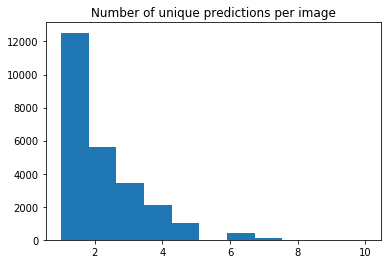

In [84]:
preds_uniq = {k: np.unique(v[0]) for k, v in preds_10_crop.items()}
preds_hist = np.array([len(x) for x in preds_uniq.values()])

plt.hist(preds_hist, bins=11)
plt.title('Number of unique predictions per image')

In [85]:
preds_top_1 = {k: collections.Counter(v[0]).most_common(1) for k, v in preds_10_crop.items()}

top_5_per_ix = {k: collections.Counter(preds_10_crop[k][1].reshape(-1)).most_common(5) 
                for k, v in preds_10_crop.items()}
preds_top_5 = {k: [y[0] for y in v] for k, v in top_5_per_ix.items()}

In [91]:
%%time
right_counter = 0
for i in range(len(y_test)):
    guess, actual = preds_top_1[i][0][0], y_test[i]
    if guess == actual:
        right_counter += 1
        
print('Top-1 Accuracy, 10-Crop: {0:.2f}%'.format(float(right_counter) / len(y_test) * 100))

Top-1 Accuracy, 10-Crop: 84.93%
CPU times: user 19.5 ms, sys: 0 ns, total: 19.5 ms
Wall time: 18.2 ms


In [92]:
%%time
top_5_counter = 0
for i in range(len(y_test)):
    guesses, actual = preds_top_5[i], y_test[i]
    if actual in guesses:
        top_5_counter += 1
        
print('Top-5 Accuracy, 10-Crop: {0:.2f}%'.format(float(top_5_counter) / len(y_test) * 100))

Top-5 Accuracy, 10-Crop: 96.76%
CPU times: user 17.8 ms, sys: 0 ns, total: 17.8 ms
Wall time: 16.6 ms
